In [4]:
import threading
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from deepc import Controller, RandomNoiseDiscreteLTI

# Define a system
system = RandomNoiseDiscreteLTI(
    A=[[0.88, 0.1, 0.0], 
       [0.1, 0.8, 0.1], 
       [0.0, 0.1, 0.88]],
    B=[[0.01, 0, 0], 
       [0, 0.01, 0], 
       [0, 0, 0.01]],
    C=[[10, 0, 0], 
       [0, 10, 0], 
       [0, 0, 10]],
    D=[[0, 0, 0], 
       [0, 0, 0], 
       [0, 0, 0]],
    x_ini=[1, 1, 1],
   noise_std=0.1
)

# Define constraints for the input
min_input = 0
max_input = 4
constraint = lambda u: np.clip(u, min_input, max_input)

# Define how many steps the controller should look back
# to grasp the current state of the system
T_ini = 10

# Define how many steps the controller should look forward
r_len = 10

In [2]:
# Gather offline data interactively
# until the condition number of the matrix G is low enough
# to ensure a stable controller
u_d = []
y_d = []
g_cond = []
is_running = True

def gather_data():
    global is_running
    while is_running:
        u = np.random.uniform(min_input, max_input, system.input_dim)
        y = system.apply(u)
        u_d.append(u)
        y_d.append(y)

        if len(u_d) < T_ini + r_len:
            continue

        G = Controller(u_d, y_d, T_ini, r_len, input_constrain_fkt=constraint).G
        g_cond.append(np.linalg.cond(G))
        
        plt.clf()
        plt.plot(g_cond, label="cond(G)")
        plt.yscale("log")
        plt.legend()
        display(plt.gcf())
        clear_output(wait=True)

thread = threading.Thread(target=gather_data).start()

try:
    while True:
        time.sleep(0.1)
except KeyboardInterrupt:
    is_running = False

# Reset the system
# to sepereate the offline data from the online data
system.set_state([0, 0, 0])  # This is intentionally not the same state as x_ini

Assessment of U_p:
Dimensions: (30, 220)
Rank: 30, Condition Number: 12.35090481644114
Suggested dimensions (U): 28 (retaining 99.0% energy)
Assessment of U_f:
Dimensions: (30, 220)
Rank: 30, Condition Number: 12.513640534919665
Assessment of Y_p:
Dimensions: (30, 220)
Rank: 30, Condition Number: 845.779548428577
Suggested dimensions (Y): 1 (retaining 99.0% energy)
Assessment of Y_f:
Dimensions: (30, 220)
Rank: 30, Condition Number: 851.029904448925


RuntimeError: functools.partial(<function FigureCanvasAgg.print_png at 0x73affb5b3e20>, orientation='portrait') did not call Figure.draw, so no renderer is available

<Figure size 640x480 with 1 Axes>

Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x73affbb0dd00>

<Figure size 640x480 with 1 Axes>

Assessment of U_p:
Dimensions: (30, 220)
Rank: 30, Condition Number: 12.35090481644114
Suggested dimensions (U): 28 (retaining 99.0% energy)
Assessment of U_f:
Dimensions: (30, 220)
Rank: 30, Condition Number: 12.513640534919665
Assessment of Y_p:
Dimensions: (30, 220)
Rank: 30, Condition Number: 845.779548428577
Suggested dimensions (Y): 1 (retaining 99.0% energy)
Assessment of Y_f:
Dimensions: (30, 220)
Rank: 30, Condition Number: 851.029904448925


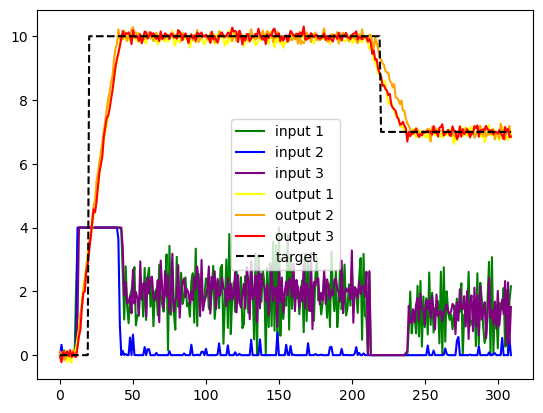

In [3]:
controller = Controller(u_d, y_d, T_ini, r_len, input_constrain_fkt=constraint)

# Warm up the controller
while not controller.is_initialized():
    u = [0, 0, 0]
    y = system.apply(u)
    controller.update(u, y)

# Simulate the system
u_online = []
y_online = []
r_online = [[0, 0, 0]] * 20 + [[10, 10, 10]] * 200 + [[7, 7, 7]] * 100
for i in range(len(r_online) - r_len):
    r = r_online[i: i + r_len]
    u = controller.apply(r)[0]
    y = system.apply(u)
    controller.update(u, y)
    u_online.append(u)
    y_online.append(y)

# Plot the results
plt.plot([u[0] for u in u_online], label="input 1", color="green")
plt.plot([u[1] for u in u_online], label="input 2", color="blue")
plt.plot([u[2] for u in u_online], label="input 3", color="purple")
plt.plot([y[0] for y in y_online], label="output 1", color="yellow")
plt.plot([y[1] for y in y_online], label="output 2", color="orange")
plt.plot([y[2] for y in y_online], label="output 3", color="red")
plt.plot([r[0] for r in r_online[:len(y_online)]], label="target", color="black", linestyle="--")
plt.legend()